https://ieeexplore.ieee.org/document/8465970
https://link.springer.com/article/10.1007/s11760-021-02061-7

In [121]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from scipy.signal import convolve2d, convolve
from scipy.ndimage import filters
# https://stackoverflow.com/questions/45960192/using-numpy-as-strided-function-to-create-patches-tiles-rolling-or-sliding-w/45960193#45960193
def window_nd(a, window, steps = None, axis = None, gen_data = False):
        """
        Create a windowed view over `n`-dimensional input that uses an 
        `m`-dimensional window, with `m <= n`
        
        Parameters
        -------------
        a : Array-like
            The array to create the view on
            
        window : tuple or int
            If int, the size of the window in `axis`, or in all dimensions if 
            `axis == None`
            
            If tuple, the shape of the desired window.  `window.size` must be:
                equal to `len(axis)` if `axis != None`, else 
                equal to `len(a.shape)`, or 
                1
                
        steps : tuple, int or None
            The offset between consecutive windows in desired dimension
            If None, offset is one in all dimensions
            If int, the offset for all windows over `axis`
            If tuple, the steps along each `axis`.  
                `len(steps)` must me equal to `len(axis)`
    
        axis : tuple, int or None
            The axes over which to apply the window
            If None, apply over all dimensions
            if tuple or int, the dimensions over which to apply the window

        gen_data : boolean
            returns data needed for a generator
    
        Returns
        -------
        
        a_view : ndarray
            A windowed view on the input array `a`, or `a, wshp`, where `whsp` is the window shape needed for creating the generator
            
        """
        ashp = np.array(a.shape)
        
        if axis != None:
            axs = np.array(axis, ndmin = 1)
            assert np.all(np.in1d(axs, np.arange(ashp.size))), "Axes out of range"
        else:
            axs = np.arange(ashp.size)
            
        window = np.array(window, ndmin = 1)
        assert (window.size == axs.size) | (window.size == 1), "Window dims and axes don't match"
        wshp = ashp.copy()
        wshp[axs] = window
        assert np.all(wshp <= ashp), "Window is bigger than input array in axes"
        
        stp = np.ones_like(ashp)
        if steps:
            steps = np.array(steps, ndmin = 1)
            assert np.all(steps > 0), "Only positive steps allowed"
            assert (steps.size == axs.size) | (steps.size == 1), "Steps and axes don't match"
            stp[axs] = steps
    
        astr = np.array(a.strides)
        
        shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
        strides = tuple(astr * stp) + tuple(astr)
        
        as_strided = np.lib.stride_tricks.as_strided
        a_view = np.squeeze(as_strided(a, 
                                     shape = shape, 
                                     strides = strides))
        if gen_data :
            return a_view, shape[:-wshp.size]
        else:
            return a_view

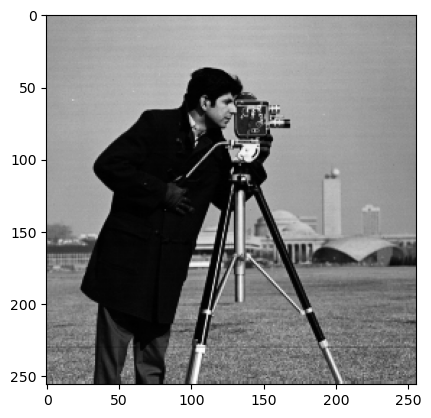

(256, 256) uint8


In [114]:
def plot_images_horizontal(images, titles):
    n_rows = 1
    n_cols = len(images)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    cmap = None if len(images[0].shape) == 3 else 'gray'

    for idx, image in enumerate(images):
        axes[idx].imshow(image, cmap=cmap)
        axes[idx].set_title(titles[idx])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

im = np.asarray(Image.open('photographer.jpg'))
if len(im.shape) == 3:
    im = np.mean(im, axis=2)
plt.imshow(im, cmap='gray')
plt.show()

print(im.shape, im.dtype)

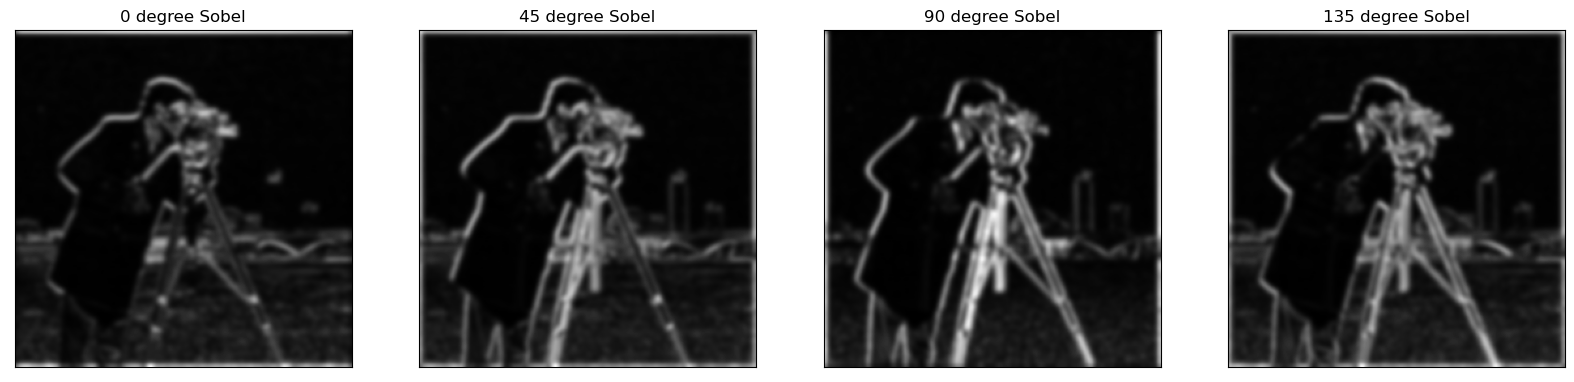

In [115]:
sobel_0 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_45 = np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])
sobel_90 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_135 = np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]])

sobel_list = [sobel_0, sobel_45, sobel_90, sobel_135]
sobel_titles = ['0 degree Sobel', '45 degree Sobel', '90 degree Sobel', '135 degree Sobel']

# DM_k(x, y) = |fk(x, y) * I(x, y)|
DM_list = []
for sobel_kernel in sobel_list:
    DM_k = abs(convolve(im, sobel_kernel))
    DM_k = filters.gaussian_filter(DM_k, sigma=2)

    DM_list.append(DM_k)

plot_images_horizontal(DM_list, sobel_titles)
plt.show()


In [116]:
n = 16 # Cell Size
k = n # Stride
b = n * 2 # Block Size

# "We divide into p overlapping blocks and calculate the feature vector of each block"
# "K is the stride between two neighbor blocks"
# "The cell size is n x n"
# "We set k = n in our experiments"
DM_blocks = []
for DM in DM_list:
    blocks = window_nd(im, (b, b), steps=k).reshape(-1, b, b)
    DM_blocks.append(blocks)

# HOE is calculated based on the DMs
# Each block contains four connected cells
# We combine the histograms of the four pixels corresponding to the center locations of the four connected cells
# The histogram of each center pixel is 4 bins since there are four orientations
def extract_edge_descriptor(blocks):
    # Get the center pixel
    c_row = b // 2
    c_col = b // 2

    # Get the offset to move the center from the middle of the block to the middle of one of the four cells
    row_offset = c_row // 2
    col_offset = c_col // 2

    # Get the four cell pixel centers
    centers = [
        (c_row - row_offset, c_col - col_offset),
        (c_row - row_offset, c_col + col_offset),
        (c_row + row_offset, c_col - col_offset),
        (c_row + row_offset, c_col + col_offset)
    ]

    # For each center, create the histogram from the DMs
    feature_vector = []

    for row_coord, col_coord in centers:
        for block in blocks:
            feature_vector.append(block[row_coord, col_coord])

    # "In each block the feature vector is normalized by the L2 norm"
    return feature_vector / np.linalg.norm(feature_vector)

histogram_of_oriented_edge = []
for idx in range(DM_blocks[0].shape[0]):
    blocks = [
        DM_blocks[0][idx],
        DM_blocks[1][idx],
        DM_blocks[2][idx],
        DM_blocks[3][idx],
    ]

    descriptor = extract_edge_descriptor(blocks)
    histogram_of_oriented_edge.extend(descriptor)


print(len(histogram_of_oriented_edge))


3600


In [117]:
descriptor

array([0.22136373, 0.22136373, 0.22136373, 0.22136373, 0.28342833,
       0.28342833, 0.28342833, 0.28342833, 0.18205615, 0.18205615,
       0.18205615, 0.18205615, 0.29584124, 0.29584124, 0.29584124,
       0.29584124])

In [118]:
# https://stackoverflow.com/questions/31774071/implementing-log-gabor-filter-bank
import math

number_scales = 4          # scale resolution
number_orientations = 6    # orientation resolution
N = 128                    # image dimensions
def getFilter(f_0, theta_0):
    # filter configuration
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

    # x,y grid
    extent = np.arange(-N/2, N/2 + N%2)
    x, y = np.meshgrid(extent,extent)

    mid = int(N/2)
    ## orientation component ##
    theta = np.arctan2(y,x)
    center_angle = ((np.pi/number_orientations) * theta_0) if (f_0 % 2) \
                else ((np.pi/number_orientations) * (theta_0+0.5))

    # calculate (theta-center_theta), we calculate cos(theta-center_theta) 
    # and sin(theta-center_theta) then use atan to get the required value,
    # this way we can eliminate the angular distance wrap around problem
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    ds = sintheta * math.cos(center_angle) - costheta * math.sin(center_angle)    
    dc = costheta * math.cos(center_angle) + sintheta * math.sin(center_angle)  
    dtheta = np.arctan2(ds,dc)

    orientation_component =  np.exp(-0.5 * (dtheta/angle_bandwidth)**2)

    ## frequency componenet ##
    # go to polar space
    raw = np.sqrt(x**2+y**2)
    # set origin to 1 as in the log space zero is not defined
    raw[mid,mid] = 1
    # go to log space
    raw = np.log2(raw)

    center_scale = math.log2(N) - f_0
    draw = raw-center_scale
    frequency_component = np.exp(-0.5 * (draw/ scale_bandwidth)**2)

    # reset origin to zero (not needed as it is already 0?)
    frequency_component[mid,mid] = 0

    return frequency_component * orientation_component

Gabor took 0.005sec
convolve took 0.010sec


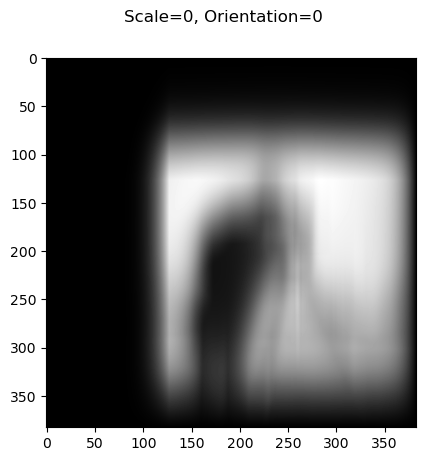

Gabor took 0.002sec
convolve took 0.004sec


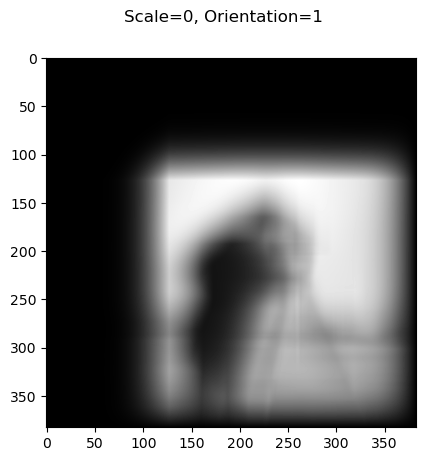

Gabor took 0.002sec
convolve took 0.004sec


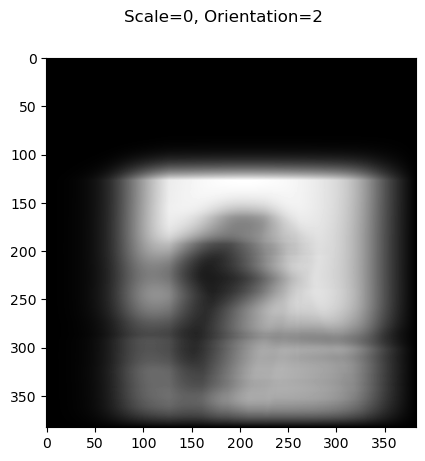

Gabor took 0.001sec
convolve took 0.004sec


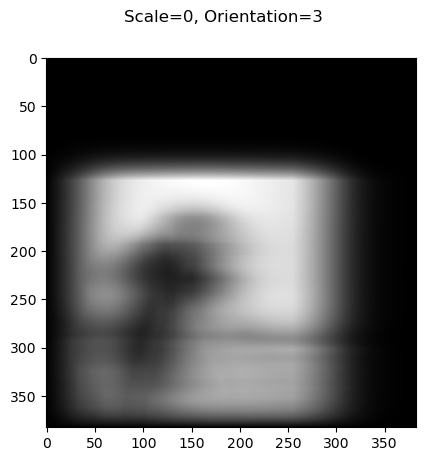

Gabor took 0.001sec
convolve took 0.004sec


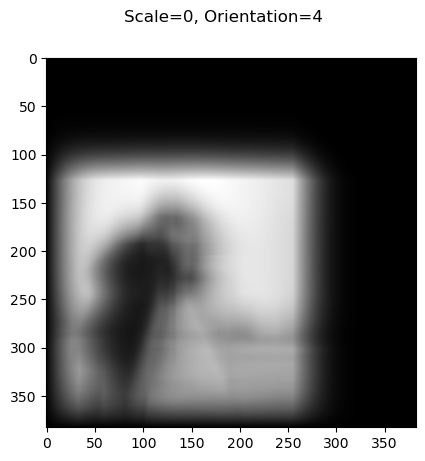

Gabor took 0.005sec
convolve took 0.010sec


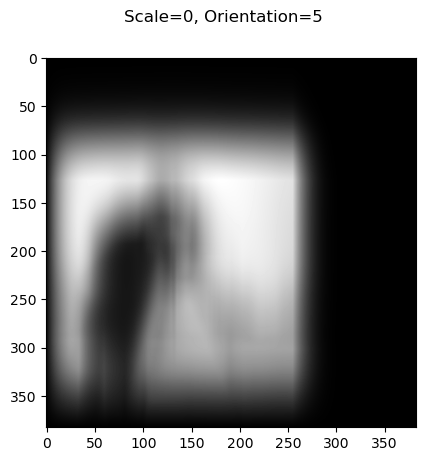

Gabor took 0.002sec
convolve took 0.004sec


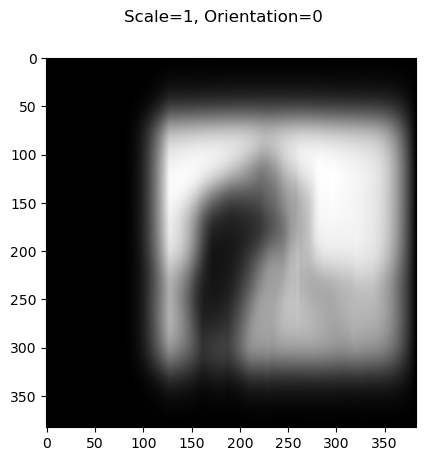

Gabor took 0.003sec
convolve took 0.007sec


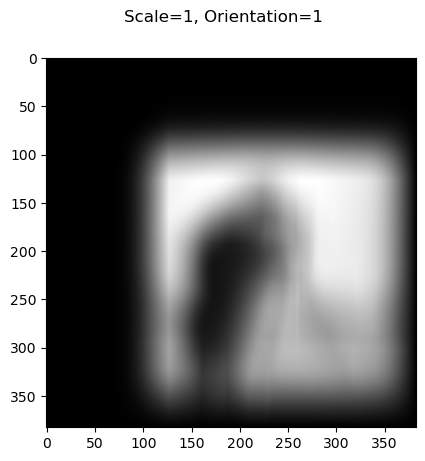

Gabor took 0.001sec
convolve took 0.004sec


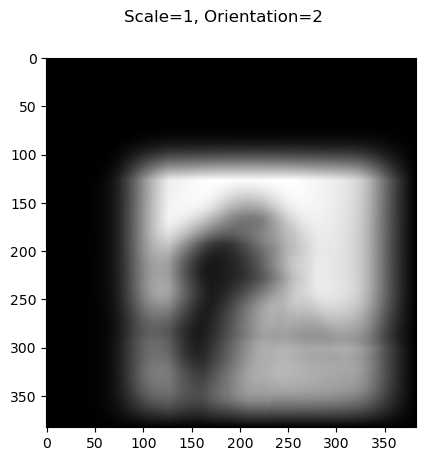

Gabor took 0.002sec
convolve took 0.010sec


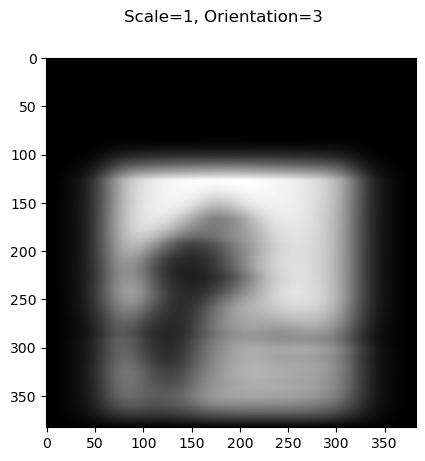

Gabor took 0.001sec
convolve took 0.004sec


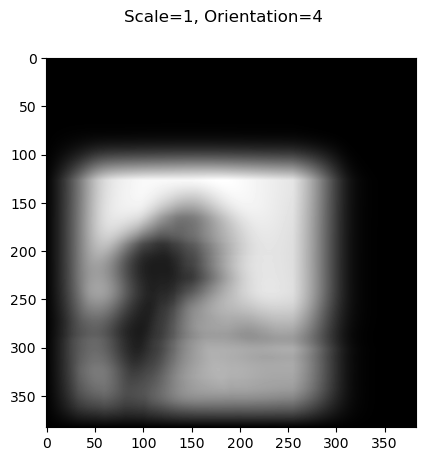

Gabor took 0.001sec
convolve took 0.004sec


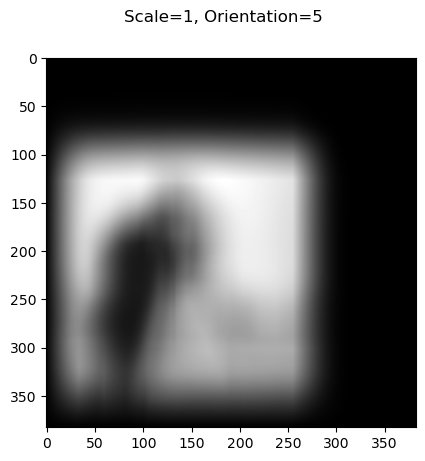

Gabor took 0.001sec
convolve took 0.004sec


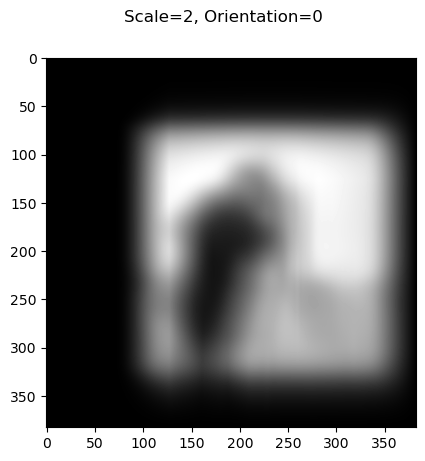

Gabor took 0.001sec
convolve took 0.004sec


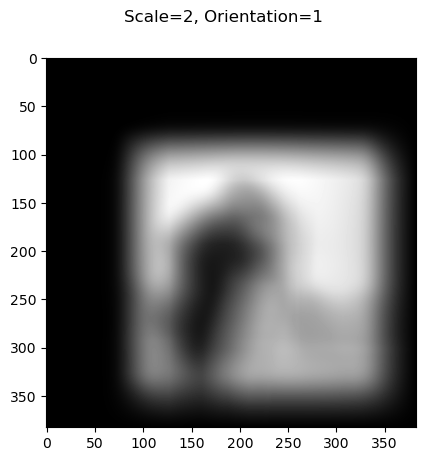

Gabor took 0.002sec
convolve took 0.004sec


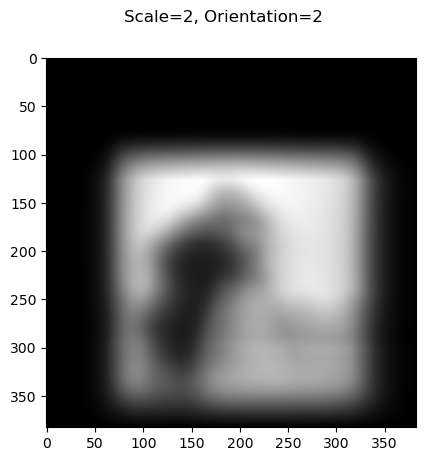

Gabor took 0.002sec
convolve took 0.004sec


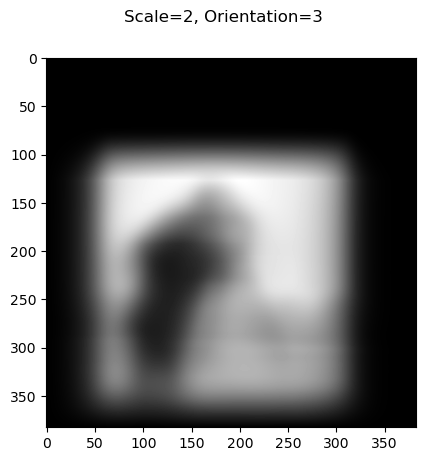

Gabor took 0.001sec
convolve took 0.004sec


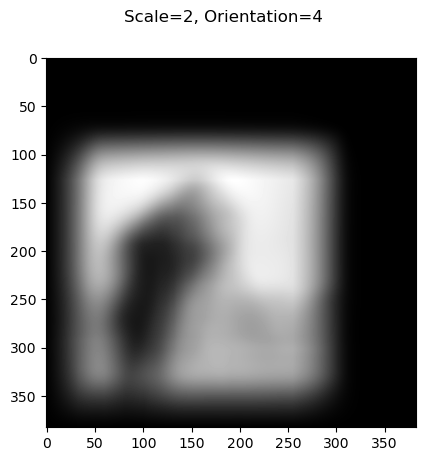

Gabor took 0.001sec
convolve took 0.004sec


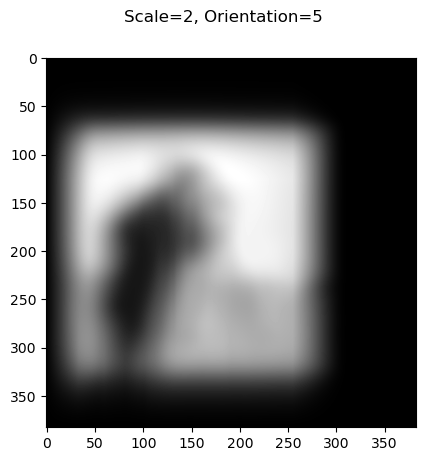

Gabor took 0.002sec
convolve took 0.004sec


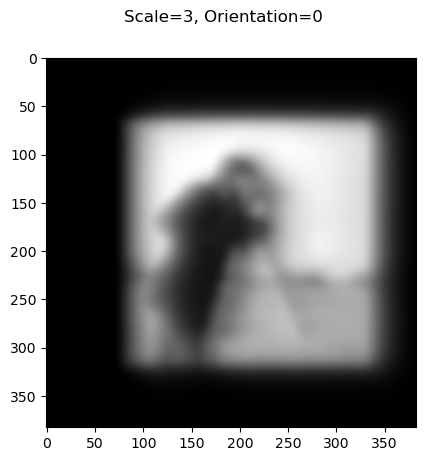

Gabor took 0.002sec
convolve took 0.004sec


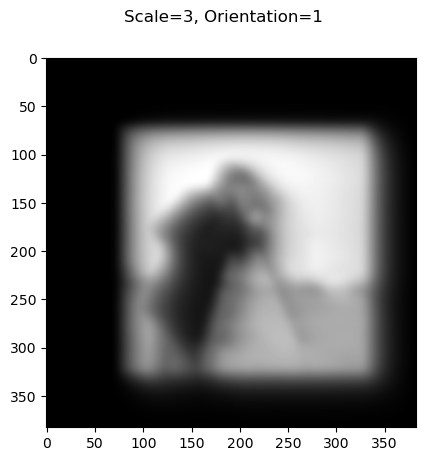

Gabor took 0.005sec
convolve took 0.009sec


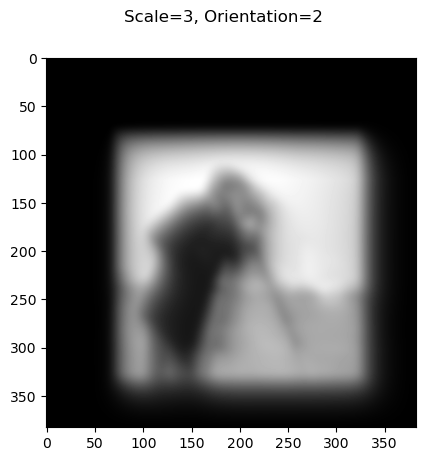

Gabor took 0.001sec
convolve took 0.004sec


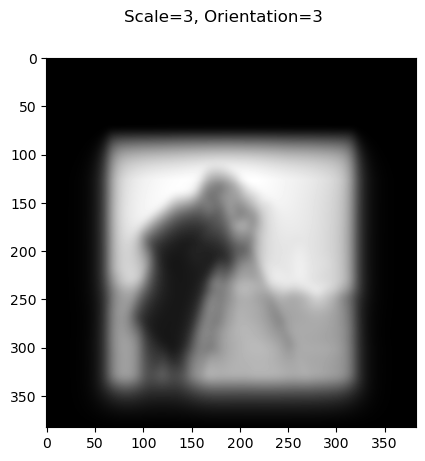

Gabor took 0.002sec
convolve took 0.004sec


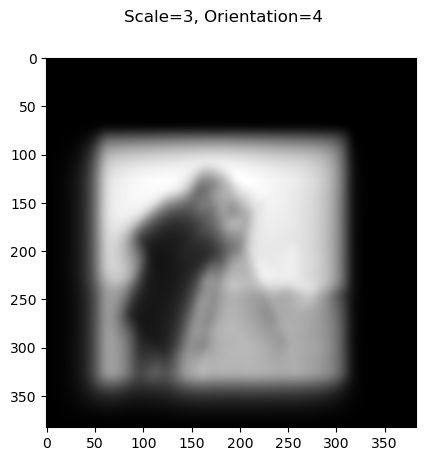

Gabor took 0.002sec
convolve took 0.004sec


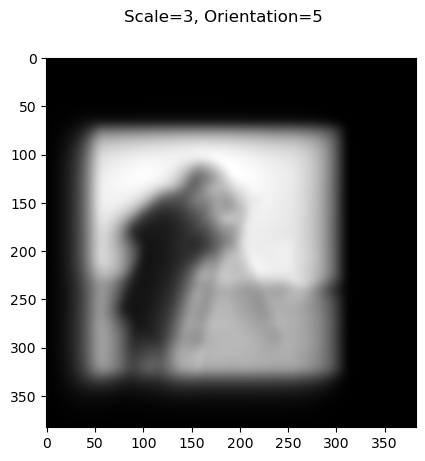

In [125]:
from timeit import default_timer as timer
for s in range(number_scales):
    for o in range(number_orientations):
        start_time = timer()
        g = getFilter(s, o)
        end_time = timer()

        print(f'Gabor took {end_time-start_time:.3f}sec')

        start_time = timer()
        A = abs(convolve(im, g))
        end_time = timer()
        print(f'convolve took {end_time-start_time:.3f}sec')

        plt.suptitle(f'Scale={s}, Orientation={o}')
        plt.imshow(A, cmap='gray')
        plt.show()
